<a href="https://colab.research.google.com/github/danielalcalde/MCMC_CRBM/blob/master/Ising_CRBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulating the Ising model with Next-Nearest-Neighbor (NNN) interactions model using a CRBM

Via Metropolis sampling and Convolutional RBM (CRBM) with Gibbs sampling, we will try to simulate the spin-$\frac{1}{2}$ Heisenberg antiferromagnet in two dimensions:
$$
H = J_1 \sum_{\langle i,j \rangle} s_i s_j + J_2 \sum_{\langle \langle i,j \rangle \rangle} s_i s_j
$$
where $J_1 > 0$, $J_2 \geq 0$, $s_i = \pm 1$, $\langle i,j \rangle$ denotes nearest-neighbor sites, and $\langle \langle i,j \rangle \rangle$ denotes NNN sites. In the case of $J_1 > 0, J_2=0$.

### References

https://journals.aps.org/prb/abstract/10.1103/PhysRevB.76.064528

https://journals.aps.org/prb/abstract/10.1103/PhysRevB.79.014439

https://journals.aps.org/prb/abstract/10.1103/PhysRevB.84.174407

https://journals.aps.org/prb/pdf/10.1103/PhysRevB.45.7832

https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.63.2148

https://aip.scitation.org/doi/10.1063/1.1664978

# Importing necessary libraries

In [220]:
import numpy as np
import tensorflow as tf
from IPython import display
import pandas as pd
import time
import matplotlib.pyplot as plt

In [221]:
import sys
sys.path.append('../')
import ising_analysis
import importlib
importlib.reload(ising_analysis)

<module 'ising_analysis' from '/Users/ecasiano/Desktop/IsingConvolutionalRBM/ising_analysis.py'>

Set seed for reproducibility.

In [222]:
np.random.seed(1968)
tf.random.set_seed(1968)

Accuracy used for training and numerics.

In [223]:
floatX = np.float32

In [224]:
t0 = time.time()

# Helping functions

Tensorflow has no implementation of the binomial function. With help of random.uniform the behaviour can be replicated.

In [225]:
def binomial(means):
    return (tf.sign(means - tf.random.uniform(tf.shape(means))) + 1 ) / 2

This functions creates periodic padding so that the convolution has periodic boundary conditions. When performing the transposed convolution step the padding is placed at the oposite side.

In [226]:
def periodic_padding(x, kernel_size=2, deconv=False):
    '''
    x: shape (batch_size, d1, d2)
    return x padded with periodic boundaries. i.e. torus or donut
    '''
    pad_r = kernel_size // 2
    pad_l = kernel_size - pad_r - 1
    
    d1, d2 = x.shape[1: 3]
    
    # When deconvolving the pading should reverses
    if deconv:
        p = pad_r
        pad_r = pad_l
        pad_l = p   

    top_left = x[:, d1 - pad_l:, d2 - pad_l:]
    top_center = x[:, d1 - pad_l:, :]
    top_right = x[:, d1 - pad_l:, :pad_r]

    middle_left = x[:, :, d2 - pad_l:]
    middle_center = x
    middle_right = x[:, :, :pad_r]

    bottom_left = x[:, :pad_r, d2 - pad_l:]
    bottom_center = x[:, :pad_r, :]
    bottom_right = x[:, :pad_r, :pad_r]
    
    top = tf.concat([top_left, top_center, top_right], axis=2)
    middle = tf.concat([middle_left, middle_center, middle_right], axis=2)
    bottom = tf.concat([bottom_left, bottom_center, bottom_right], axis=2)
    padded_x = tf.concat([top, middle, bottom], axis=1)
    return padded_x

a = tf.Variable(np.arange(4 * 4).reshape(1, 4, 4))
print(a[0].numpy())
print()
print(periodic_padding(a,2)[0].numpy())

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]

[[ 0  1  2  3  0]
 [ 4  5  6  7  4]
 [ 8  9 10 11  8]
 [12 13 14 15 12]
 [ 0  1  2  3  0]]


# Dataset Generation

In [227]:
def to_int(x):
    if x == '0' or x == '1': return int(x)
    else: return 0

#This will generate all posible LxL matrices with {0,1}^(LxL) don't use with more then L=4
def bit_string(L):
    maxim = 2 ** (L ** 2)
    a = np.asarray([[to_int(x) for x in list(('{0:' + str(L ** 2) + 'b}').format(i))] for i in range(maxim)], dtype=floatX)
    return a.reshape(2 ** (L ** 2), L, L)

def load_and_reshape(spins_filename):
    'loads flattened 2d ising spins data from MC and substitutes -1s to 0s and reshapes'
    data = np.loadtxt(spins_filename,dtype=floatX)
    data[data==-1] = 0
    num_configs = int(data.shape[0])
    L = int(np.sqrt(data.shape[1]))
    return data.reshape((num_configs,L,L,1))

Generate all posible $3\times3$ states

In [228]:
L_train = 4
states_train_all_4by4 = bit_string(L_train)[:, :, :, None]
states_train_all_4by4.shape

(65536, 4, 4, 1)

Load spin configurations from Monte Carlo simulation

In [229]:
# states_train = load_and_reshape("uncorrelated_monte_carlo_data/L_5_T_2.25_spins_seed_0.dat");
states_train = states_train_all_4by4

Generate a random test set of lattice size $L=50$ to evaluate if the CRBM matches the Ising model at large lattice sizes.

In [230]:
L = 32
states_test = np.asarray(np.random.binomial(size=(4 * 10 ** 3, L, L, 1), p=0.5, n=1), dtype=floatX)
states_test.shape

(4000, 32, 32, 1)

Define the energy of given state for the Ising model: $E(s)=-\sum_{<ij>}s_is_j$

In [231]:
def ising_energy(states,J1,J2):
    states = 2 * states - 1

    nb = np.roll(states, shift=-1, axis=1) + np.roll(states, shift=-1, axis=2)
    
    # Roll states down/left
    states_down = np.roll(states, shift=+1, axis=1)
    states_downleft = np.roll(states_down, shift=-1, axis=2)
    
    # Roll states up/left
    states_up = np.roll(states, shift=-1, axis=1)
    states_upleft = np.roll(states_up, shift=-1, axis=2)
    
    nb_nnn = states_downleft + states_upleft
    
    # Energy contribution from nearest-neighbor interaction
    energy_nn = +J1*np.sum(states * nb, axis=(1, 2, 3)) 
    
    # Energy contribution from next-nearest-neighbor interaction
    energy_nnn = +J2*np.sum(states * nb_nnn, axis=(1, 2, 3))
    
    return energy_nn + energy_nnn

In [232]:
def ising_magnetization(states):
    states = 2 * states - 1
    
    # Energy contribution from next-nearest-neighbor interaction
    magnetization = np.sum(states, axis=(1, 2, 3))
    
    return magnetization

In [233]:
# Set physical parameters
temp = 2.27
J1 = -1.0
J2 = 0.0

# # Neel order phase
# temp = 1.25
# J1 = 6.0
# J2 = 1.0

# # Striped (Colliner) phase
# temp = 1.0
# J1 = 1.0
# J2 = 1.0

The physical energy is computed for train and test set.

In [234]:
E_phys_train = ising_energy(states_train,J1=J1,J2=J2)
E_phys_test = ising_energy(states_test,J1=J1,J2=J2)
E_phys_train.shape

(65536,)

The CRBM will be trained by batches of 64 states.

In [235]:
TRAIN_BUF = E_phys_train.shape[0]
BATCH_SIZE = 2 ** 6
N_TRAIN_BATCHES = TRAIN_BUF// BATCH_SIZE

train_dataset = tf.data.Dataset.from_tensor_slices((states_train, E_phys_train)).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
BATCH_SIZE

64

# The Model

Random Initializion: the kernel W with kernel_dims=(kernel_number, kernel_size) and both biases.

In [236]:
kernel_dims = (2,2)
kernel_shape = (kernel_dims[1], kernel_dims[1], 1, kernel_dims[0])

In [237]:
def get_param(beta):
    e4b = np.exp(4 * beta)
    e2b = np.exp(2 * beta)

    W = np.log(-1 + 2 * e4b + 2 * e2b * np.sqrt(e4b - 1))

    Wk = np.zeros((2, 2, 1, 2), dtype=floatX)
    Wk[0, :, 0, 0] = W
    Wk[:, 0, 0, 1] = W

    vbias = np.asarray([-2 * W], dtype=floatX)
    hbias = np.array([-W, -W], dtype=floatX)

    return Wk, vbias, hbias

The negative log likelihood also called free energy: \\
$F(v) = -v_\text{bias} \sum_{i,j} v_{ij} -\sum_{i,j,k} \log(1+e^{(v*W^k)_{ij} +h^k_\text{bias}})$

$P(h|x): x \rightarrow h$  
$P(h^k_{ij}=1|v)=\sigma((W^k * v)_{ij} + h_\text{bias}^k) ) $

$P(x|h): h \rightarrow x$  
$P(v_{ij}=1|h)=\sigma((\sum_k \bar{W}^k * h^k)_{ij} +v_\text{bias}))$


$P(x'|x): x \rightarrow h\rightarrow x'$


Computing the loss function:  
$\text{diff}(x) = E(x) - F(x)$  
$C = \frac{1}{M} \sum_x \text{diff}(x)$  
$\text{loss} = \sum_x (\text{diff}(x) - C)^2$  

In [238]:
class CRBM:
    def __init__(self, kernel_dims, opt=None):
        
        assert len(kernel_dims) == 2
        if opt is None:
            opt = tf.keras.optimizers.Adam()
            
        self.opt = opt
        
        self.kernel_shape = (kernel_dims[1], kernel_dims[1], 1, kernel_dims[0])
        self.kernel_dims = kernel_dims
        
        multi = np.prod(self.kernel_shape)
        W_np = np.asarray(np.random.randn(*self.kernel_shape) * np.sqrt(2 / multi), dtype=floatX)

        W = tf.Variable(W_np*2)

        vbias = tf.Variable(np.zeros(1, dtype=floatX))
        hbias = tf.Variable(np.zeros(kernel_dims[0], dtype=floatX))

        self.W = W
        self.hbias = hbias
        self.vbias = vbias


        # Learning parameters
        self.params = [self.W, self.vbias, self.hbias]

    def n_log_like(self, v):
        input4D = periodic_padding(v, self.kernel_dims[1])
        kernels4D = self.W

        # Convolution
        out = tf.nn.conv2d(input4D, kernels4D, strides=1, padding="VALID")
        out += self.hbias[None, None, None, :]

        # Same as softplus(x)=log(1 + exp(x))
        hidden_term_not = tf.math.softplus(out)
        hidden_term = tf.reduce_sum(hidden_term_not, axis=(1, 2, 3))

        visible_term = tf.reduce_sum(v, axis=(1, 2)) * self.vbias[None, :]
        visible_term = tf.reduce_sum(visible_term, axis=1)

        return -hidden_term - visible_term

    def set_analytical_param(self, beta):
        W, vbias, hbias = get_param(beta)
        self.W.assign(W)
        self.hbias.assign(hbias)
        self.vbias.assign(vbias)

    def prop_vis_to_hid(self, v):
        input4D = periodic_padding(v, self.kernel_dims[1])
        kernels4D = self.W
        
        # Convolution
        out = tf.nn.conv2d(input4D, kernels4D, strides=1, padding="VALID")
        
        out += self.hbias[None, None, None, :]
        
        mean_activation = tf.math.sigmoid(out)
        # print("h_layer: ",binomial(mean_activation))
        return binomial(mean_activation)
        
    
    def prop_hid_to_vis(self, h):
        input4D = periodic_padding(h, self.kernel_dims[1], deconv=True)
        kernels4D = tf.transpose(self.W[::-1, ::-1], [0, 1, 3, 2])

        # Convolution
        out = tf.nn.conv2d(input4D, kernels4D, strides=1, padding="VALID")
        
        out += self.vbias[None, None, None, :]
        
        mean_activation = tf.math.sigmoid(out)
        return binomial(mean_activation)
    
    @tf.function
    def gibbs(self, state):
        return self.prop_hid_to_vis(self.prop_vis_to_hid(state))
    
    
    @tf.function
    def gibbs_k(self, state, k=1):
        
        i = tf.constant(0)
        cond = lambda i, state: tf.less(i, k)

        def operation(i, state):
            i += 1
            state = self.gibbs(state)
            return i, state

        _, state = tf.while_loop(cond, operation, [i, state])
        
        return state
    
    @tf.function
    def compute_loss(self, x, nll_phys):
        # x: states
        # nll_phys: physical energy of states x
        # nll_crcm: free energy of states x
        nll_crbm = self.n_log_like(x)

        diff = nll_phys - nll_crbm
        C = tf.reduce_mean(diff)
        
        # add regularization term!
        
        loss = tf.reduce_mean((diff - C) ** 2)
        return loss
    
    def compute_grad(self, x, nll_phys):
        # compute the grad

        ### pass through network
        with tf.GradientTape() as tape:
            loss = self.compute_loss(x, nll_phys)

        grad = tape.gradient(loss, self.params)
        return grad, loss


    @tf.function
    def train(self, x, nll_phys):
        grad, loss = self.compute_grad(x, nll_phys)

        self.opt.apply_gradients(zip(grad, self.params))
        return loss
    
    # Symmetrization functions
    def generate_R90_groups(self):
        
        # Should generalize to even linear size kernels

        L = self.kernel_dims[1]
        
        unique_vectors = []
        length = L-1
        for i in range(L//2):
            for j in range(i,i+length):

                unique_vectors.append([i,j])

            length -= 2
        unique_vectors = np.array(unique_vectors,dtype=np.float32)
        
        # Shift vectors to place origin at center site (for odd) or center (for even) 
        if L%2!=0:
            shift = L//2
        else:
            shift = (L//2-0.5)
        unique_vectors -= shift
            
        # Apply rotation matrix to get the 4 rotations
        R = np.array([[0,1],[-1,0]])
        rotations = np.zeros((unique_vectors.shape[0],4,2),dtype=np.float32)
        for i,vec in enumerate(unique_vectors):
            for rot in range(4):
                rotations[i][rot] = vec
                vec = R@vec

        # Shift rotationally equivalent vectors back to have center at top left corner
        rotations += shift
        rotations = rotations.astype(np.int32)
        return rotations

    # @tf.function
    def symmetrize_rotations(self,R90_groups):
        for group in R90_groups:
            W_mean = tf.zeros(kernel_dims[0])
            for angle in range(4):
                row,col = group[angle]
                W_mean += self.W[row,col] 
            W_mean /= 4.0

            for angle in range(4):
                row,col = group[angle]
                self.W[row,col].assign(W_mean)

    # Symmetrization functions
    @tf.function
    def symmetrize_reflections(self):
        
        kernel_size = self.kernel_dims[1]
        
        if kernel_size%2 !=0: 
            start_right = kernel_size//2+1
        else:
            start_right = kernel_size//2
        start_bottom = start_right
        
        # Get left-half of Ising lattice
        # print("kernel_size: ",kernel_size)
        # print("kernel_size//2: ",kernel_size//2)
        left_half = self.W[:,0:kernel_size//2,:,:]
        right_half = self.W[:,start_right:,:,:]
        right_half = right_half[:,::-1,:,:] # Reflection of right-half

        # Take average of sites symmetrical about vertical axis
        left_right_mean = (left_half+right_half)/2.0
        
        self.W[:,0:kernel_size//2,:,:].assign(left_right_mean)
        self.W[:,start_right:,:,:].assign(left_right_mean[:,::-1,:,:])
        
        # Get top-half of Ising lattice
        # print("kernel_size: ",kernel_size)
        # print("kernel_size//2: ",kernel_size//2)
        top_half = self.W[0:kernel_size//2,:,:,:]
        bottom_half = self.W[start_bottom:,:,:,:]
        bottom_half = bottom_half[::-1,:,:,:] # Reflection of bottom-half

        # Take average of sites symmetrical about horizontal axis
        top_bottom_mean = (top_half+bottom_half)/2.0
        
        self.W[0:kernel_size//2,:,:,:].assign(top_bottom_mean)
        self.W[start_bottom:,:,:,:].assign(top_bottom_mean[::-1,:,:,:])

# Training

We create an CRBM object and train it. One can see that both the train_loss and the test_loss decrease simulaniously. The expected difference between the two losses should be around $\frac{t_{test}}{t_{train}}=\frac{N_{test}^2}{N^2_{train}}=\frac{50^2}{3^2}=277.77$. Note that our objective is that $F_{RBM}(x)=\beta E(x)+C$.

In [239]:
crbm = CRBM(kernel_dims=kernel_dims)

In [240]:
use_analytical_param = False

In [241]:
if use_analytical_param:
    crbm.set_analytical_param(1 / temp)

In [242]:
# # Plot trained kernel
# W = crbm.W.numpy()
# vmax = np.max(abs(W))

# fig, axes = plt.subplots(nrows=1, ncols=kernel_dims[0])

# for i in range(kernel_dims[0]):
#     im = axes[i].imshow(W[:, :, 0, i], vmin =-vmax, vmax=vmax, cmap="seismic")

# # Deactivate axes
# for i in range(kernel_dims[0]):
#     axes[i].set_xticks([])
#     axes[i].set_yticks([])
#     axes[i].set_xlabel(f'$W^{i}$', fontsize=20)
    
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# fig.colorbar(im, cax=cbar_ax);

In [243]:
# Numerical values of initial kernel
# for i in range(kernel_dims[0]):
#     print(W[:, :, 0, i],'\n')

In [244]:
loss_train = []
loss_test = []
epoch = 0

Epoch: 0 | loss test: 341.2018737792969| loss train: 6.753403186798096| ltest/ltrain: 50.522953033447266


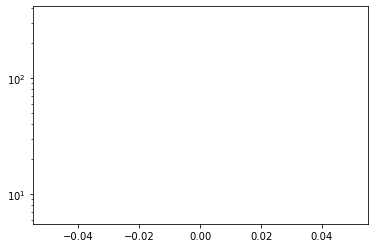

CPU times: user 23.4 s, sys: 3.22 s, total: 26.6 s
Wall time: 23.5 s


In [245]:
%%time
l_train = 10 ** 9
l_test = 10 ** 9

# Choose if we'll do symmetrizations
do_symmetrization = False
if do_symmetrization: 
    modelType="with_symmetries"
    R90_groups = crbm.generate_R90_groups()
else: modelType="no_symmetries"

while l_train > 10 ** -8:
# while epoch < 5000:
    # train
    l_train = 0
        
    for train_s, train_E in train_dataset:
        l_train += crbm.train(train_s, train_E / temp)
        
        if do_symmetrization:
            # Symmetrize 90 degree rotations
            crbm.symmetrize_rotations(R90_groups)

            # Symmetrize horizontal,vertical axis reflections
            crbm.symmetrize_reflections()
    
    l_train = l_train / N_TRAIN_BATCHES
        
    # plot results    
    if epoch % 25 == 0:
        l_test = crbm.compute_loss(states_test, E_phys_test / temp)
        
        loss_train.append(l_train) 
        loss_test.append(l_test)
        
        display.clear_output(wait=True)

        print(
            f"Epoch: {epoch} | loss test: {loss_test[-1]}| loss train: {loss_train[-1]}| ltest/ltrain: {loss_test[-1]/loss_train[-1]}"
        )
        plt.plot(loss_train,color='tab:blue')
        plt.plot(loss_test,color='tab:orange')
        plt.yscale("log")
        plt.show()
    epoch += 1
# plt.savefig('L_'+str(L)+'_T_'+str(temp)+'_kernelDims_'+str(kernel_dims[0])+'-'+str(kernel_dims[1])+'_'+modelType+'_training.dat')
# plt.show()

### Should we add extra training loop with MC data?

In [246]:
# MC Training loop here

In [247]:
l_train

<tf.Tensor: shape=(), dtype=float32, numpy=3.7220356e-09>

In [248]:
l_test = crbm.compute_loss(states_test, E_phys_test / temp)

In [249]:
l_test

<tf.Tensor: shape=(), dtype=float32, numpy=1.9488707e-05>

## The learned convolutional kernels show the effective interaction between nearest neighbours.

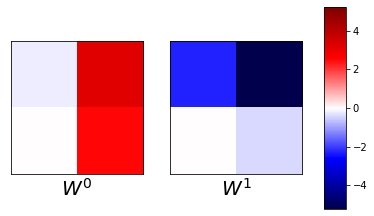

In [250]:
# Plot trained kernel
W = crbm.W.numpy()
vmax = np.max(abs(W))

if kernel_dims[0]>1:
    fig, axes = plt.subplots(nrows=1, ncols=kernel_dims[0])
    for i in range(kernel_dims[0]):
        im = axes[i].imshow(W[:, :, 0, i], vmin =-vmax, vmax=vmax, cmap="seismic")
    # Deactivate axes
    for i in range(kernel_dims[0]):
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].set_xlabel(f'$W^{i}$', fontsize=20)
else:
    fig, axes = plt.subplots()
    for i in range(kernel_dims[0]):
        im = axes.imshow(W[:, :, 0, i], vmin =-vmax, vmax=vmax, cmap="seismic")
    # Deactivate axes
    for i in range(kernel_dims[0]):
        axes.set_xticks([])
        axes.set_yticks([])
        axes.set_xlabel(f'$W^{i}$', fontsize=20)
   
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax);

In [251]:
# Numerical values of initial kernel
for i in range(kernel_dims[0]):
    print(W[:, :, 0, i],'\n')

[[-1.7923360e-01  3.2008915e+00]
 [ 8.2886627e-06  2.5359862e+00]] 

[[-2.2470593e+00 -5.2249136e+00]
 [ 5.6181948e-06 -3.8208392e-01]] 



In [252]:
crbm.hbias

<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([-2.0486066,  3.443091 ], dtype=float32)>

In [253]:
crbm.vbias

<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.04520971], dtype=float32)>

#### Test free energy: $F(\mathbf{v})$

In [254]:
# Generate spin configuration
np.random.seed(0)
tf.random.set_seed(0)

L = 3
num_configs = 10
v = np.random.randint(0,2,num_configs*L*L*1)*1.0
v = v.reshape((num_configs,L,L,1)).astype(np.float32)

In [255]:
crbm.n_log_like(v) - np.min(crbm.n_log_like(v))

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([1.9073486e-06, 1.7621193e+00, 3.5242310e+00, 5.2863369e+00,
       1.7621212e+00, 0.0000000e+00, 1.7621155e+00, 1.7621155e+00,
       1.7621155e+00, 1.7621136e+00], dtype=float32)>

# Sampling

A state with $L=40$ is updated $5\times10 ^4$ times using gibbs sampling.  Because the temperature T=1, is well bellow the critical temperature TC=2.269 it converges to the ground state.

In [256]:
modelType = 'no_symmetries'

In [257]:
L = 64
states = tf.random.uniform((1, L, L, 1))

In [258]:
# Open file for writing
filename = './data_nnn/L_'+str(L)+'_T_'+str(temp)+'_J1_'+str(J1)+'_J2_'+str(J2)+'_kernelDims_'+str(kernel_dims[0])+'-'+str(kernel_dims[1])+'_'+modelType+'.dat'
file = open(filename, "w")
header = "#L=%d, T=%.2f \n# E     M     E^2     M^2\n"
file.write(header)

# Initialize quantities to measure
E = 0.0
M = 0.0
E_squared = 0.0
M_squared = 0.0

bin_size = 1

In [259]:
%%time
epochs = 50000
equilibration_steps = 100000
not_equilibrated = True
Es = []
Ms = []
Es_squared = []
Ms_squared = []
print('Equilibrating...')
i = 0
while i < epochs:
    
    while not_equilibrated:
        states = crbm.gibbs(states)
        i+=1
    
        if i==equilibration_steps:
            print('Equilibrated!')
            print('Sampling and measuring observables...')
            not_equilibrated = False
            i = 0
    
    # After equilibration, measure observables
    states = crbm.gibbs(states)
    E = ising_energy(states,J1,J2)[0]
    Es.append(E)
    
    M = ising_magnetization(states)[0]
    Ms.append(M)
    
    # E_squared = E**2
    # Es_squared.append(E_squared)

    file.write('%.8f %.8f %.8f %.8f\n'%(E/bin_size,M/bin_size,E_squared/bin_size,M_squared/bin_size))
        
    i += 1
    
print('Done!')

Equilibrating...
Equilibrated!
Sampling and measuring observables...
Done!
CPU times: user 2min 30s, sys: 8.81 s, total: 2min 39s
Wall time: 2min 15s


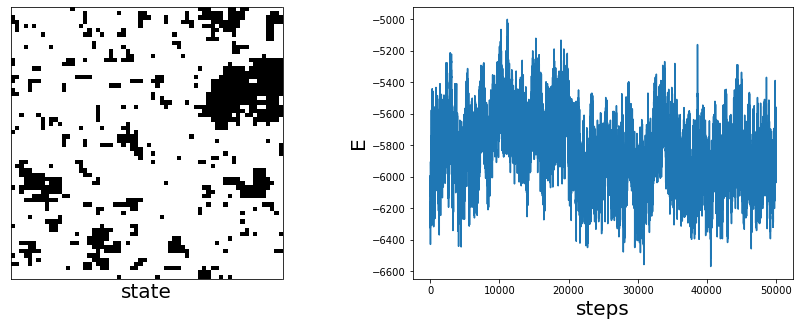

In [260]:
# Plot latest spin configuration and energy at each sampling step 

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].imshow(states.numpy()[0, :, :, 0], vmin=0, vmax=1, cmap="gray")
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_xlabel('state', fontsize=20)

axes[1].plot(Es)
axes[1].set_xlabel(f'steps', fontsize=20)
axes[1].set_ylabel(f'E', fontsize=20)
display.clear_output(wait=True)
plt.savefig('./figures/L_'+str(L)+'_T_'+str(temp)+'_J1_'+str(J1)+'_J2_'+str(J2)+'_kernelDims_'+str(kernel_dims[0])+'-'+str(kernel_dims[1])+'_'+modelType+'_state&energy.pdf',dpi=300)
# plt.savefig('L_'+str(L)+'_T_'+str(temp)+'_kernelDims_'+str(kernel_dims[0])+'-'+str(kernel_dims[1])+'_'+modelType+'.pdf',dpi=300)
plt.show()

In [261]:
# Close file if finished sampling
file.close()

In [262]:
e_exact = ising_analysis.e_exact_func(temp)
e_exact

-1.4108644329892681

In [263]:
e_CRBM = np.mean(Es)/L**2
e_CRBM

-1.4251747131347656

In [264]:
relErr = np.abs((e_exact-e_CRBM)/e_exact)
relErr

0.010142916506285168

The minimal energy is $2L^2$

#### 

### Save weights

In [154]:
# create object
# model=tensorflow.keras.Model()
 
# assign location
filename = './data_nnn/L_'+str(L)+'_T_'+str(temp)+'_J1_'+str(J1)+'_J2_'+str(J2)+'_kernelDims_'+str(kernel_dims[0])+'-'+str(kernel_dims[1])+'_'+modelType+'_weights.dat'

# save
crbm.save("lol")

AttributeError: 'CRBM' object has no attribute 'save'

# Thermodynamic constants at different temperatures

Until now we only trained as CRBM at a $T=1$. Train differnt CRBM at different $T$s.




In [ ]:
def train(T, crbm=None):
    if crbm is None:
        crbm = CRBM(kernel_dims=(2, 2))
    
    l_train = 10 ** 9
    l_test = 10 ** 9
    epoch = 0
    while l_train > 10 ** -4:
        # train
        l_train = 0

        for train_s, train_E in train_dataset:
            l_train += crbm.train(train_s, train_E / T)
        
        l_train = l_train / N_TRAIN_BATCHES

        # plot results

        if epoch % 100 == 0:
            l_test = crbm.compute_loss(states_test, E_phys_test / T)

            display.clear_output(wait=True)

            print(
                f"Temp: {T} | Epoch: {epoch} | loss test: {l_test}| loss train: {l_train}"
            )
        epoch += 1
   
    return crbm   

In [37]:
Ts = np.linspace(1.5, 3.5, 25)

Train different CRBM's at different temperatures.

In [38]:
#%%time
#crbms = [train(T) for T in Ts]

Faster. Train a CRBM at a temperature, save it, and then modify it's temperature and retrain it at the new temperature.

In [39]:
"""
%%time
crbm = train(Ts[0])
crbms = [crbm]
T_old = Ts[0]
for T in Ts[1:]:
    crbm_new = CRBM(kernel_dims=(2, 2))
    
    crbm_new.W.assign(crbm.W / T * T_old )
    crbm_new.vbias.assign(crbm.vbias / T * T_old)
    crbm_new.hbias.assign(crbm.hbias / T * T_old)
    
    W_old = crbm_new.W.numpy()
    crbm = train(T, crbm_new)
    W_new = crbm.W.numpy()
    
    crbms.append(crbm)
""";

Alternatively, the CRBM can also be initialized directly with the analytical solution so that no further training is necessary.

In [40]:
crbms = []
for T in Ts:
    crbm = CRBM(kernel_dims=(2, 2))
    crbm.set_analytical_param(1 / T)
    crbms.append(crbm)

# Montecarlo Simulations

The functions performs gibbs steps with a CRBM and saves the energy and magnetization in arrays.

In [41]:
def MC(crbm, states, steps, hidden_steps=10):
    Es = np.empty(steps)
    Ms = np.empty(steps)
    
    for i in range(steps):
        states = crbm.gibbs_k(states, k=hidden_steps)
        
        # Get the state out of the gpu
        state_np = states.numpy()
        Es[i] = ising_energy(state_np)[0]
        Ms[i] = (2 * state_np - 1).sum()
              
    return Es, Ms, states

This function will plot the thermodynamic constants

In [42]:
def plot_thermodynamics(Temp, Es, Cvs, mag, susceptibility):
    # ----------------------------------------------------------------------
    # Plot the Energy, Magnetization, Specific Heat and Susceptibility
    # ----------------------------------------------------------------------

    f = plt.figure(figsize=(18, 10), dpi=80, facecolor='w', edgecolor='k')
    xlabel = "T"
    
    sp = f.add_subplot(2, 2, 1)
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel("Energy ", fontsize=20)
    plt.scatter(Temp, Es)

    sp = f.add_subplot(2, 2, 2)
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel("Magnetization ", fontsize=20)
    plt.scatter(Temp, abs(np.array(mag)))
    plt.axvline(x=2.269)
    
    sp = f.add_subplot(2, 2, 3)
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel("Specific Heat ", fontsize=20)

    plt.scatter(Temp, Cvs)
    plt.axvline(x=2.269)

    sp = f.add_subplot(2, 2, 4);
    plt.xlabel(xlabel, fontsize=20);
    plt.ylabel("Susceptibility", fontsize=20);
    
    plt.scatter(Temp, susceptibility)
    plt.axvline(x=2.269)

    plt.show()

Initialize the step that will be used during the MC. There is an oportunity for parallelization in the Gpu if severall states are updated in the simulation. For simplicity only one states is used.



In [43]:
L = 10
states = tf.random.uniform((1, L, L, 1))

We start with the highest temperature and slowly lower it. First there is a warmup phase and then thermodynamic constants are recorded.

Temp:  1.5


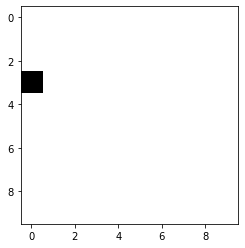

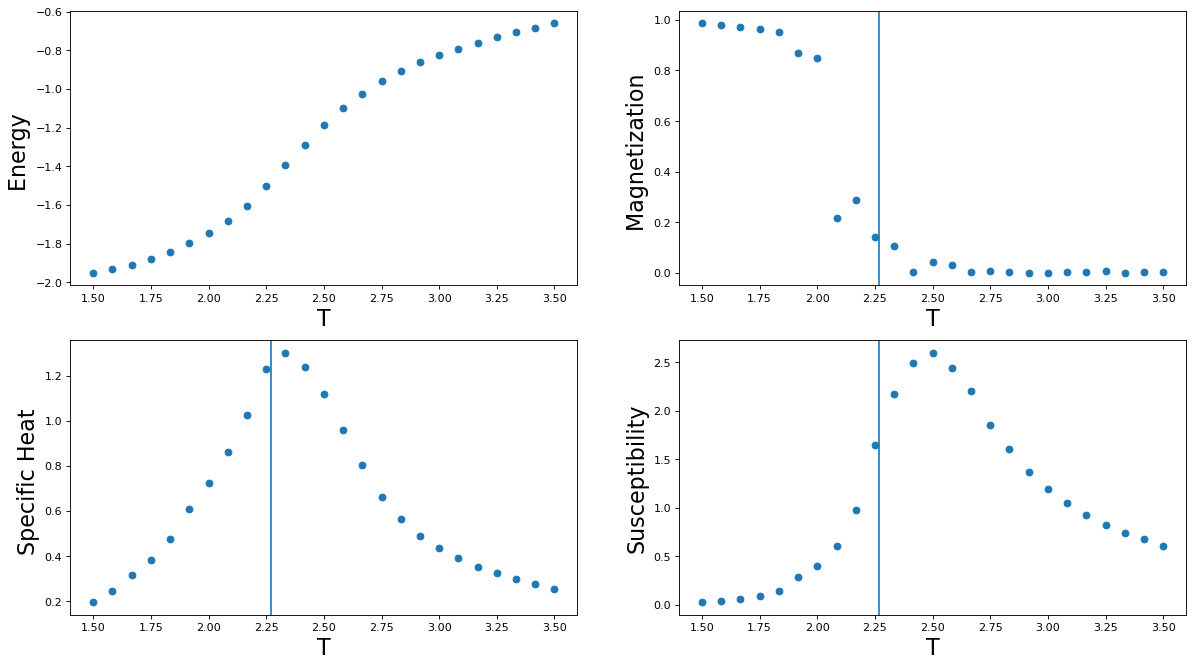

CPU times: user 13min 15s, sys: 1min 7s, total: 14min 23s
Wall time: 12min 36s


In [44]:
%%time

energy = []
magnetization = []
CV = []
susceptibility = []

e, m, states = MC(crbms[-1], states, 2 * 10 ** 4)
for i, crbm in enumerate(crbms[::-1]):
    # Warmup
    e, m, states = MC(crbm, states, 10 ** 3)
    
    # Mc Simulation
    e, m, states = MC(crbm, states,  2 * 10 ** 4)
    
    # Computing expectaion values
    e1 = e.mean()
    e2 = (e ** 2).mean()
    
    m1 = m.mean()
    absm1= abs(m).mean()
    m2 = (m ** 2).mean()
    
    
    energy.append(e1 / L ** 2)
    magnetization.append(m1 / L ** 2)
    CV.append( (e2 - e1 ** 2) / Ts[-i - 1] ** 2 / L ** 2 )
    susceptibility.append( (m2 - absm1 ** 2) / Ts[-i - 1] / L ** 2 )
    
    
    display.clear_output(wait=True)
    print("Temp: ", Ts[-i -1])
    plt.imshow(states.numpy()[0, :, :, 0], vmin=0, vmax=1, cmap="gray")
    plt.show()
    
    # Plot thermodynamics
    plot_thermodynamics(Ts[-i - 1:], energy[::-1], CV[::-1], magnetization[::-1], susceptibility[::-1])

Above you can see that the Magnetization colapses to 0 after the critical temperature $T_c=2.269$ and that the specific heat is maximal around $T_c$ as expected.

In [45]:
t1 = time.time()
(t1 - t0) / 60

16.271534983317057